<font color='red'>**注意** N006 で作成した全周ベジエ近似の関数を利用していますので、N006 を完了させていないと N007 は実行できません.</font>

# ベジエ近似の応用　その１　曲率計算

曲率の大きさや曲率の極大点の位置は品種や個体の形状特徴の一つである。

このノートでは、ベジエ近似曲線の応用のひとつとして、曲率計算と曲率の極大点の抽出を取り上げる。


## 1. 全周ベジエ近似について


ベジエ曲線は円などの閉曲線を正確に記述することはできない。（複数のセグメントに分けて区分的に近似することはできる）

また、始点、終点をどこにでも設定できるため回転不変性はないので、全周を近似するためには、人間が始点・終点を指定するか、あるいは回転不変な特徴点を基準にして始点・終点を定めざるを得ない。逆に言えば、そのような点が設定できるのであれば自動で近似可能であるとも言える。

例えば、

- 曲率最大点
- 重心から最短の輪郭点。逆に最遠の輪郭点
- 最も遠い輪郭点のペアのうちの１点

などの方法も考えられる。

N005 で示したダイコン画像の自動分割のアルゴリズムでは、対称性を尺度として上下端点を見つけたが、その２つの点を起点とするというのも手である。


## 2. 曲率関数

N005 で既に示したことであるが、パラメトリック曲線の曲率は、

$$\frac{1}{R}=\frac{(x'(t)y''(t) - y'(t)x''(t))}{(x'(t)^2 + y'(t)^2)^{3/2}}$$

で表せる。ベジェ曲線もパラメトリック曲線であるので、この式が有効である。

この式は負の値となることがあるのは明らかである。もし、曲率を曲線状の各点での偏角の変化率に一致する円の半径の逆数、と捉えるならば、分母は絶対を取って評価する必要がある。

曲率の正負は、パラメータの増加する方向に対して左に反る具合を表す。正ならば曲率中心は左にあり、負ならば右にある。

例えば、円を、その円周上の１点から反時計回りに進むならば、曲率は正の値となり、逆ならば負となる。

<font color='orange'>*（注）これは、ｘ方向とｙ方向をそれぞれ右、上に取り、反時計回りを回転の正方向と定義した場合の話である。OpenCV を含め、画像処理ではしばしばｙ方向が逆向きに取られるので、上式通りに計算すると正負が反転するので注意が必要である。*</font>


-　[曲率・曲率半径 (curvature and radius of curvature)](http://w3e.kanazawa-it.ac.jp/math/category/kika/heimenkika/henkan-tex.cgi?target=/math/category/kika/heimenkika/curvature.html)

-　[ベジェ曲線の曲率](http://geom.web.fc2.com/geometry/bezier/curvature.html)

### ベジエ近似の応用として、図形輪郭の曲率分布を求めてみよう。

曲率、あるいは曲率の出現パターンは形状の特徴のひとつであろう。近似ベジエ曲線を使って曲率の大きな点を抽出してみよう。

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var

from mpmath import mp,findroot # mpmath をすべてインポートすると、x でしか微分できなくなるので注意。

# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
# 予め求めてある全周輪郭のベジエ近似式を読み込む
Bfuncs = rd.loadPkl("fall.pkl",labhome+"/res")

## 曲率の極大・極小点を見つける

### 基本

1. 曲線のパラメトリック表現から曲率関数式が導出できる。   
2. 曲率関数の導関数が0となり、その前後で符号が反転する点が曲率極大・極小点である。  
3. 高次のベジエ曲線などでは導関数＝０の解を陽表現の数式では表せないので数値解析的に解かざるを得ない。

## ゼロクロッシング法

1. パラメトリック表現された数式から曲線上にM個のサンプル点を設定する。 
2. サンプル点における導関数の値を計算する。  
3. 隣接する２つのサンプル点の間で導関数の値の符号が反転していたら、その２点の間に極値があると判断する。（ゼロクロッシング）

隣接するサンプル点の間に極値が複数個発生しないよう、サンプル点の間隔は十分細かく設定しないといけない。

極値がいくつ存在するかは図形に依存する。次のプログラムではすべてのゼロクロッシング点を数え上げた後、曲率の絶対値の大きい順に、最大１０箇所まで抽出してプロットする。

**(補足)**　当初パラメータ空間を単純に等分割してサンプル点を決めてみたが、それだとサンプルの配置に疎密ができ、場所によってはサンプル点が疎らすぎて極点を見逃してしまうことがわかった。そこで、パラメータ空間で等間隔というやり方ではなく、少々計算量が多くなるが、実空間で等間隔なサンプルが選ばれるようにしている。

**註** *ダイコンで曲率が最大となる点は普通根の先ですが、その点を始点・終点として曲線をパラメータ表現しているため、以下の実験では根の先の位置は曲率計算の対象外となっています。根の先の位置の曲率を計算したい場合は、上端で開いた輪郭を用いるなどして試してください。*

In [2]:
# 曲率関数
def showCurvature(n,DIV=128):
    t= symbols('t')
    img = imgs[n] #  シルエット画像
    bf = Bfuncs[n] #  シルエット画像の全周のベジエ近似式
    kf = rd.curvature(bf) # 曲率式を得る
    dkf = diff(kf) # 曲率の微分
    
    # 描画準備 
    # ra = np.linspace(0,1,DIV+1) # [0,1]区間をDIV分割
    bezi = rd.BezierCurve(N=3,samples=[[0,0]]*DIV,prefunc=bf) # ベジエ曲線近似の関数を流用
    ra = bezi.ts 
    kdata = np.array([kf.subs(t,s) for s in ra]) # 各点の曲率を計算
    dkdata = np.array([dkf.subs(t,s) for s in ra]) # 各点の曲率の微係数を計算
    
    zerocross = np.where(dkdata[:-1] * dkdata[1:] < 0)[0] # ゼロクロッシングのインデックス
    zcdata = np.abs([(kdata[i]+kdata[i+1])/2 for i in zerocross]) # ゼロクロッシングしている位置の前後の曲率の大きさの平均値
    bestTenindex = np.argsort(-zcdata) # ゼロクロッシングの中のベストテンを大きい順にインデックスをならべる
    bestTenindex0 = zerocross[bestTenindex] # bestTenindex はゼロクロッシングのインデックスなので、もとのインデックスのおきかえ
    bestTenKCurvature = kdata[bestTenindex0]
    # zcpara = bestTenindex0/DIV
    zcpara = [ra[index] for index in bestTenindex0]
    
    # 描画
    fig = plt.figure(figsize=(10,4),dpi=100)
    ax1 = fig.add_subplot(121)
    ax1.plot(ra,kdata,label='Cavature')
    ax2=ax1.twinx()

    ax2.plot(ra,dkdata,color="red",label='Derivative')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2)
    
    ax3 = fig.add_subplot(122)
    ax3.imshow(img)
    # cont = [bf.subs(t,s) for s in ra]
    # contx = [int(float(x)) for [x,y] in cont]
    # conty = [int(float(y)) for [x,y] in cont]
    # ax3.plot(contx,conty)
    ax3.scatter(bf[0].subs(t,zcpara[0]),bf[1].subs(t,zcpara[0]),marker='o',color='red') # 最大曲率点
    ax3.scatter(bf[0].subs(t,zcpara[1]),bf[1].subs(t,zcpara[1]),marker='o',color='green') # ２番めに曲率の高い点
    ax3.scatter(bf[0].subs(t,zcpara[2]),bf[1].subs(t,zcpara[2]),marker='x',color='magenta') # ３番め
    ax3.scatter(bf[0].subs(t,zcpara[3]),bf[1].subs(t,zcpara[3]),marker='x',color='green') # ４番め 
    if len(zcpara[4:])>0:
        ax3.scatter([bf[0].subs(t,s) for s in zcpara[4:]],[bf[1].subs(t,s) for s in zcpara[4:]],marker='x',color='orange')
    
    return kf,dkf,zcpara


CPU times: user 25.3 s, sys: 19.6 ms, total: 25.4 s
Wall time: 25.4 s


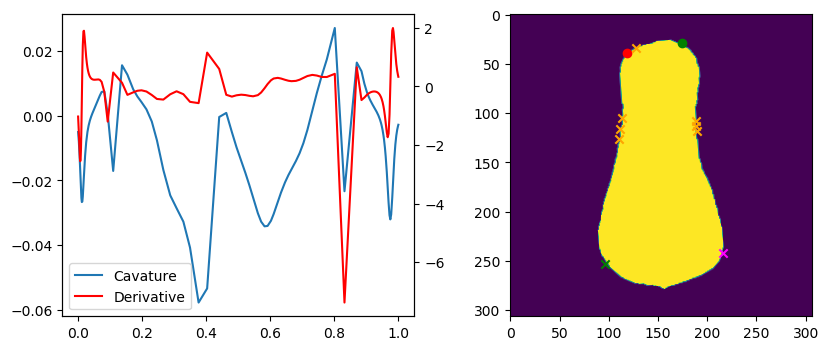

In [3]:
%%time
kf,dkf,zcpara =showCurvature(0)

- マーカのついた箇所が曲率の極大・極小点
> - 赤丸　曲率半径が当該図形で最大である点  
> - 緑丸　２番め  
> - 紫✗　３番め  
> - 緑✗　４番め
> - オレンジは順位５番目以降である

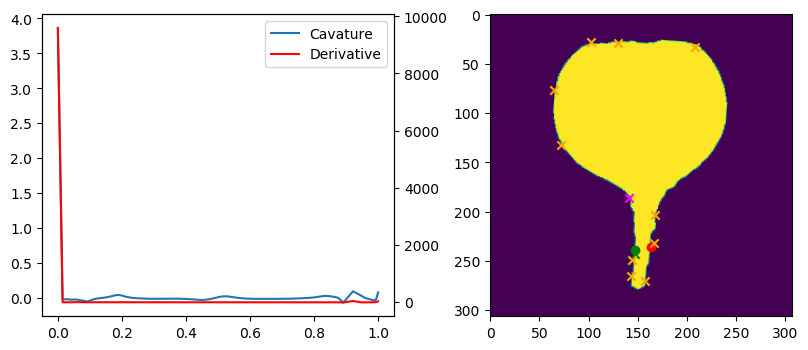

In [4]:
kf,dkf,zcpara =showCurvature(1)

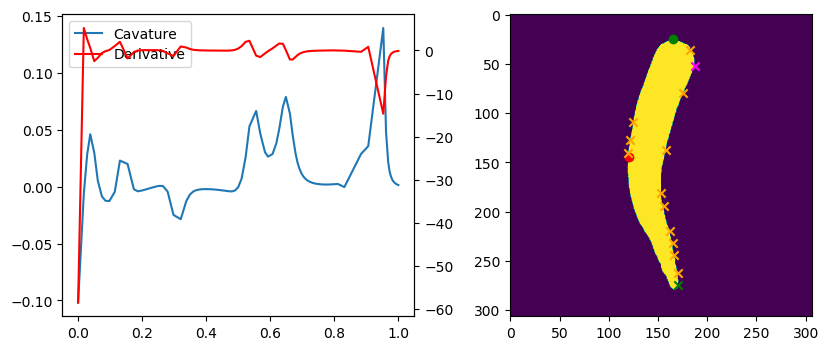

In [5]:
kf,dkf,zcpara =showCurvature(2)

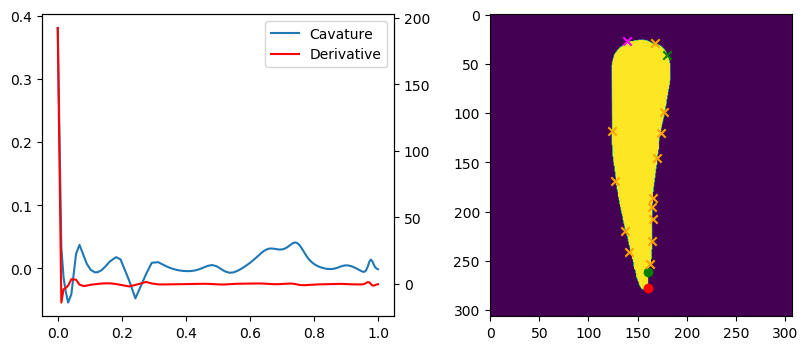

In [6]:
kf,dkf,zcpara =showCurvature(3)

# 極値を厳密に求めてみる

上のプログラムでは曲率変化の極大・極小点そのものを求めずに、微係数の反転する箇所を極大・極小点として抽出した。

もともと近似曲線であるし、十分細かくサンプリングしているので、それで十分な気もするが、数値的に厳密解を求めてみよう。

求解には、sympy の **findroot**、**ニュートン法**を用いた。ニュートン法の初期値としては、先のゼロクロッシング法の解を用いる。

In [7]:
# imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
# 予め求めてある全周輪郭のベジエ近似式を読み込む
# Bfuncs = rd.loadPkl("fall.pkl",labhome+"/res")

# 曲率関数　ニュートン求解
def showCurvature2(n,DIV=128):
    t= symbols('t')
    img = imgs[n] #  シルエット画像
    bf = Bfuncs[n] #  シルエット画像の全周のベジエ近似式
    kf = rd.curvature(bf) # 曲率式を得る
    dkf = diff(kf,t) # 曲率の微分
    
    # 描画準備 
    # ra = np.linspace(0,1,DIV+1) # [0,1]区間をDIV分割
    bezi = rd.BezierCurve(N=3,samples=[[0,0]]*DIV,prefunc=bf) # ベジエ曲線近似の関数を流用
    ra = bezi.ts 
    kdata = np.array([kf.subs(t,s) for s in ra]) # 各点の曲率を計算
    dkdata = np.array([dkf.subs(t,s) for s in ra]) # 各点の曲率の微係数を計算
    
    zerocross = np.where(dkdata[:-1] * dkdata[1:] < 0)[0] # ゼロクロッシングのインデックス
    zcdata = np.abs([(kdata[i]+kdata[i+1])/2 for i in zerocross]) # ゼロクロッシングしている位置の前後の曲率の大きさの平均値
    bestTenindex = np.argsort(-zcdata) # ゼロクロッシングの中のベストテンを大きい順にインデックスをならべる
    bestTenindex0 = zerocross[bestTenindex] # bestTenindex はゼロクロッシングのインデックスなので、もとのインデックスのおきかえ
    bestTenKCurvature = kdata[bestTenindex0]
    # zcpara = bestTenindex0/DIV
    zcpara = [ra[index] for index in bestTenindex0]
    
    # 描画
    fig = plt.figure(figsize=(10,4),dpi=100)
    ax1 = fig.add_subplot(121)
    ax1.plot(ra,kdata,label='Cavature')
    ax2=ax1.twinx()

    ax2.plot(ra,dkdata,color="red",label='Derivative')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2)
    
    ax3 = fig.add_subplot(122)
    ax3.imshow(img)

    from sympy.solvers import nsolve

    mp.dps = 100
    ans4 = []
    for i in range(len(bestTenindex0)):
        try:
            ans4.append(float(findroot(lambda x:dkf.subs(t,x),ra[bestTenindex0[i]],solver='mnewton')))
            print("{} {:7.5f} -> {:7.5f}  d {:7.5f}".format(i,ra[bestTenindex0[i]],ans4[-1],abs(ans4[-1]-ra[bestTenindex0[i]])))
        except:
            print(i,"Cannot solve")
            pass
 
    ax3.scatter(bf[0].subs(t,ans4[0]),bf[1].subs(t,ans4[0]),marker='o',color='red') # 最大曲率点
    ax3.scatter(bf[0].subs(t,ans4[1]),bf[1].subs(t,ans4[1]),marker='o',color='green') # ２番めに曲率の高い点
    ax3.scatter(bf[0].subs(t,ans4[2]),bf[1].subs(t,ans4[2]),marker='x',color='magenta') # ３番め
    ax3.scatter(bf[0].subs(t,ans4[3]),bf[1].subs(t,ans4[3]),marker='x',color='green') # ４番め 
    
    if len(zcpara[4:])>0:
        ax3.scatter([bf[0].subs(t,s) for s in zcpara[4:]],[bf[1].subs(t,s) for s in zcpara[4:]],marker='x',color='orange')

    return kf,dkf,ans4


0 0.37625 -> 0.38832  d 0.01207
1 0.58217 -> 0.58608  d 0.00391
2 0.97241 -> 0.97492  d 0.00252
3 0.01163 -> 0.01226  d 0.00063
4 0.87016 -> 0.87389  d 0.00372
5 0.13712 -> 0.13924  d 0.00212
6 0.09241 -> 0.07843  d 0.01397
7 0.07342 -> 0.07843  d 0.00502
8 0.83175 -> 0.81218  d 0.01957
9 0.80151 -> 0.81218  d 0.01068
10 0.44062 -> 0.45176  d 0.01114
CPU times: user 56.4 s, sys: 41.5 ms, total: 56.5 s
Wall time: 56.5 s


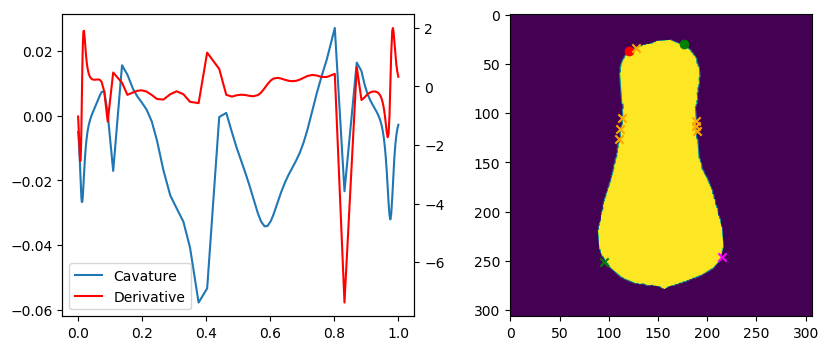

In [8]:
%%time
kf,dkf,zcpara =showCurvature2(0)

ゼロクロッシング法との解の差は僅かである。

そもそも [0,1] 区間を128分割しているので、差は 1/128 = 0.0078 に収まるはずなのだが、それ以上の場合がある。

初期値の両側の極値のうち、遠い方に収束したという可能性が考えられる。

6番と７番、8番と9番が結果的に同じ解に収束している。これは狭い範囲で曲率が細かく変動して極値が密集しているということであり、それらがまとまるのは悪いことではない。


ゼロクロッシング法の場合、標本点の位置（実際にはその中間の値を解としている）しか解として選ばれないので、標本間隔を増やせば増やすほど精度が下がるが、ニュートン法ならば標本点は初期値を決めるのに用いるだけなので、粗くしても細かい場合と同じ解に収束する可能性がある。

試してみよう。



0 0.35736 -> 0.38832  d 0.03095
1 0.57677 -> 0.58608  d 0.00931
2 0.96908 -> 0.97492  d 0.00584
3 0.01163 -> 0.01226  d 0.00063
4 0.76947 -> 0.81218  d 0.04272
5 0.41801 -> 0.45176  d 0.03375
6 0.07526 -> 0.07843  d 0.00318
CPU times: user 46 s, sys: 46.8 ms, total: 46.1 s
Wall time: 46.1 s


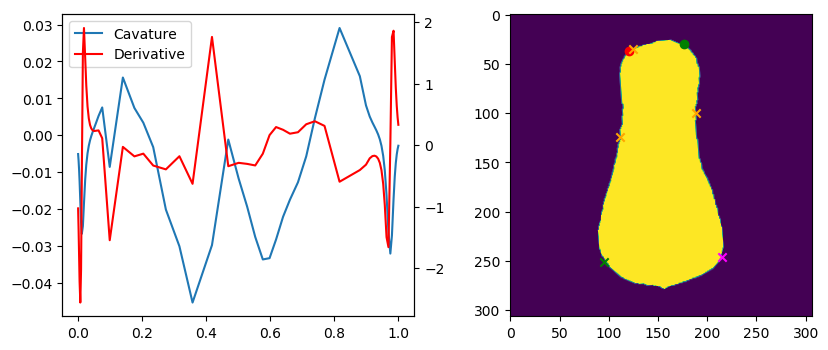

In [9]:
%%time
kf,dkf,zcpara =showCurvature2(0,DIV=64)

今回は DIV=64、標本点数 64 であるが、先の結果（DIV=128)と比べると、上から４番目までは同じ結果が得られた。

さらに標本点を３２まで減らして試してみよう。


0 0.56810 -> 0.58608  d 0.01798
1 0.96827 -> 0.97492  d 0.00666
2 0.01215 -> 0.01226  d 0.00011
3 0.33192 -> 0.81218  d 0.48026
4 0.87016 -> 0.87389  d 0.00372
5 0.44857 -> 0.45176  d 0.00320
6 0.10955 -> 0.10783  d 0.00172
CPU times: user 41.8 s, sys: 87.5 ms, total: 41.9 s
Wall time: 41.9 s


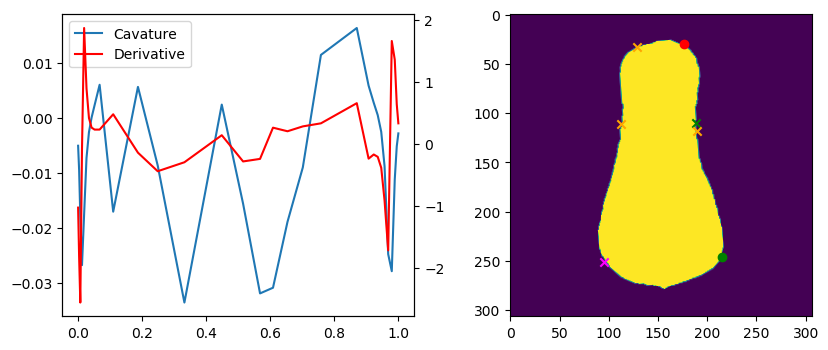

In [10]:
%%time
kf,dkf,zcpara =showCurvature2(0,DIV=32)

左上の曲率最大点が抜け落ちてしまっており、さすがにこれは粗すぎたと思うが、２，３，４番目は標本点128のときと同じ箇所に収束していることがわかる。


0 0.92162 -> 0.93004  d 0.00842
1 0.09268 -> 0.09287  d 0.00019
2 0.18725 -> 0.18768  d 0.00044
3 0.05765 -> 0.05235  d 0.00530
4 0.98655 -> 0.98803  d 0.00147
5 0.44288 -> 0.44930  d 0.00642
6 0.83612 -> 0.83630  d 0.00018
7 0.04225 -> 0.02508  d 0.01718
8 0.02195 -> 0.02508  d 0.00312
9 0.51287 -> 0.52155  d 0.00868
10 0.63913 -> 0.64230  d 0.00318
11 0.29638 -> 0.30115  d 0.00478
12 Cannot solve
13 0.35542 -> 0.36014  d 0.00471
CPU times: user 1min 8s, sys: 76.8 ms, total: 1min 8s
Wall time: 1min 8s


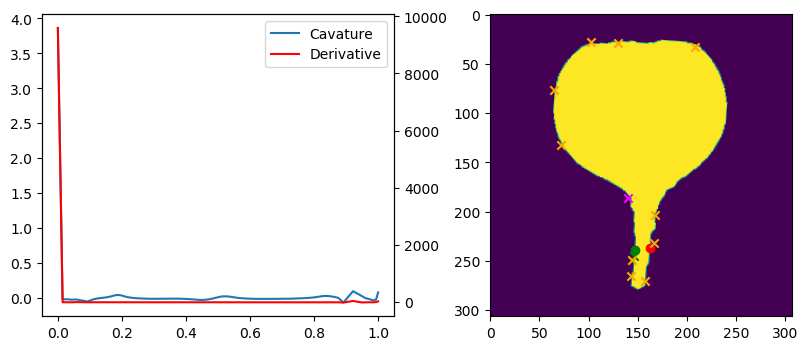

In [11]:
%%time
kf,dkf,zcpara =showCurvature2(1)


0 0.87532 -> 0.93004  d 0.05472
1 0.92162 -> 0.93004  d 0.00842
2 0.18725 -> 0.18768  d 0.00044
3 0.43699 -> 0.44930  d 0.01231
4 0.83503 -> 0.83630  d 0.00127
5 0.03496 -> 0.02508  d 0.00989
6 0.02195 -> 0.02508  d 0.00312
7 0.98655 -> 0.98803  d 0.00147
8 0.64169 -> 0.64230  d 0.00061
9 0.52048 -> 0.52155  d 0.00107
10 0.29296 -> 0.30115  d 0.00820
11 0.35092 -> 0.36014  d 0.00922
CPU times: user 53.7 s, sys: 48.9 ms, total: 53.7 s
Wall time: 53.7 s


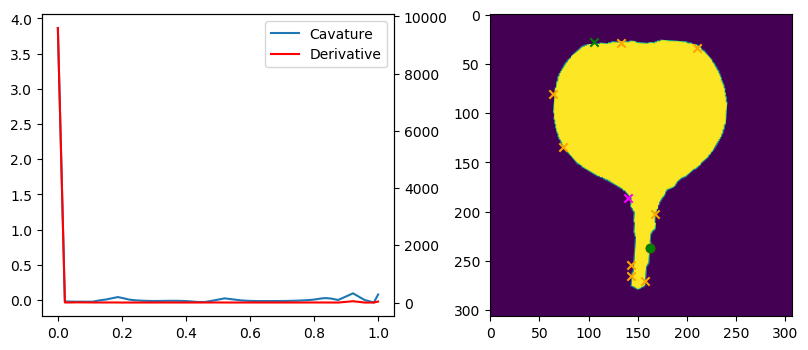

In [12]:
%%time
kf,dkf,zcpara =showCurvature2(1,DIV=64)


0 0.03284 -> 0.10414  d 0.07131
1 0.79168 -> 0.80019  d 0.00851
2 0.98441 -> 0.99213  d 0.00771
3 0.93160 -> 0.93756  d 0.00595
4 0.88166 -> 0.48948  d 0.39219
5 0.17714 -> 0.18744  d 0.01030
6 0.32559 -> 0.32967  d 0.00408
7 0.48917 -> 0.48948  d 0.00031
8 0.10026 -> 0.10414  d 0.00388
9 0.38383 -> 0.38815  d 0.00433
10 0.43058 -> 0.43124  d 0.00066
11 0.22307 -> 0.22789  d 0.00482
12 0.68614 -> 0.68995  d 0.00382
13 0.82015 -> 0.83919  d 0.01904
14 0.72721 -> 0.72976  d 0.00256
15 0.62344 -> 0.62805  d 0.00460
CPU times: user 1min 15s, sys: 90.5 ms, total: 1min 15s
Wall time: 1min 15s


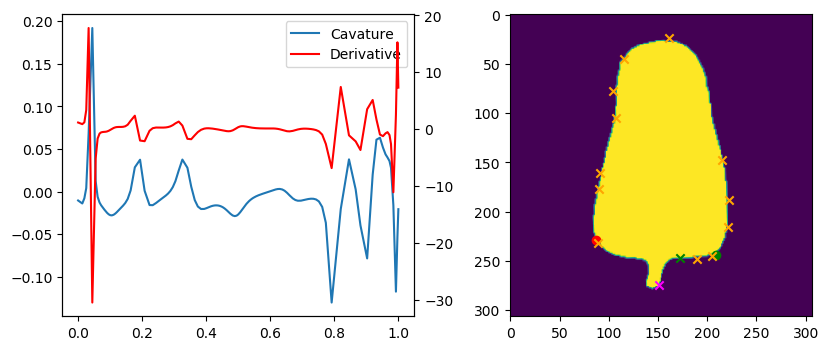

In [13]:
%%time
kf,dkf,zcpara =showCurvature2(6)


0 0.93160 -> 0.93756  d 0.00595
1 0.03402 -> 0.04091  d 0.00690
2 0.97704 -> 0.43124  d 0.54580
3 0.77140 -> 0.48948  d 0.28192
4 0.86417 -> 0.83919  d 0.02497
5 0.48592 -> 0.48948  d 0.00356
6 0.09661 -> 0.10414  d 0.00753
7 0.31731 -> 0.32967  d 0.01236
8 0.81637 -> 0.83919  d 0.02282
9 0.38726 -> 0.38815  d 0.00089
10 0.42768 -> 0.43124  d 0.00356
11 0.17903 -> 0.18744  d 0.00841
12 0.21322 -> 0.22789  d 0.01467
13 0.68504 -> 0.68995  d 0.00492
14 0.71776 -> 0.72976  d 0.01200
15 0.62085 -> 0.62805  d 0.00720
CPU times: user 1min 12s, sys: 97.6 ms, total: 1min 12s
Wall time: 1min 12s


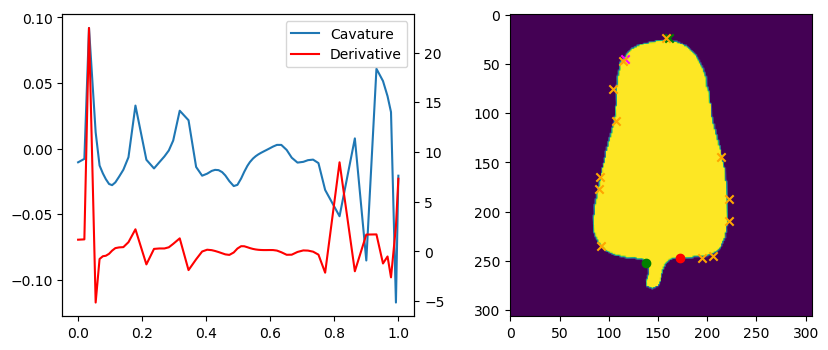

In [14]:
%%time
kf,dkf,zcpara =showCurvature2(6,DIV=64)

In [15]:
# 曲率関数の実際
kf

-1.91263267987546e-35*(-(-267602.045377121*t**16 + 65659.3419882549*t**15*(18 - 18*t) - 13591586.2059343*t**15*(2*t - 2) - 980964117.996574*t**14*(1 - t)**2 + 15883041930.2393*t**13*(1 - t)**3 - 140922189703.066*t**12*(1 - t)**4 + 741669349462.302*t**11*(1 - t)**5 - 2416830970541.12*t**10*(1 - t)**6 + 4983808044642.22*t**9*(1 - t)**7 - 6556287051040.35*t**8*(1 - t)**8 + 5486878990742.42*t**7*(1 - t)**9 - 2886492902472.05*t**6*(1 - t)**10 + 933243475913.416*t**5*(1 - t)**11 - 178142298162.147*t**4*(1 - t)**12 + 18682736574.7254*t**3*(1 - t)**13 - 944086733.857025*t**2*(1 - t)**14 + 18346260.5324632*t*(1 - t)**15 - 102947.476820965*(1 - t)**16)*(651.108604062309*t**17 + 4145.06409616338*t**16*(18 - 18*t) + 41823.8378718626*t**16*(2*t - 2) + 3551925.30105907*t**15*(1 - t)**2 - 138808773.632571*t**14*(1 - t)**3 + 2091098513.05718*t**13*(1 - t)**4 - 15936882151.5281*t**12*(1 - t)**5 + 68333222887.8536*t**11*(1 - t)**6 - 172941281234.381*t**10*(1 - t)**7 + 264094217305.67*t**9*(1 - t)**8 - 2

環境によっては、上のブロックが白紙のように見えるかもしれない。  
それは、分数式の分母が横に長く、分子が縦積みで横幅が狭いためにウィンドウ内に入りきらないからである。スクロールさせれば表示される。